In [3]:
# !pip install -r requirements.txt 

from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

# replace the absolute path to XiaomiMiMo/MiMo-VL-7B-RL
rl_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "XiaomiMiMo/MiMo-VL-7B-RL",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", # enable FlashAttention for faster inference since MiMo-VL thinks
    device_map="auto",
)

sft_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "XiaomiMiMo/MiMo-VL-7B-SFT",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", # enable FlashAttention for faster inference since MiMo-VL thinks
    device_map="auto",
)

processor = AutoProcessor.from_pretrained("/mnt/bos-multimodal/songzc/model/XiaomiMiMo/MiMo-VL-7B-RL")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
def inference(model, messages, max_new_tokens=16384, temperature=0.1, top_p=0.95, do_sample=True):
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    generated_ids = model.generate(
        **inputs, 
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=do_sample,
        pad_token_id=processor.tokenizer.eos_token_id
    )
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text

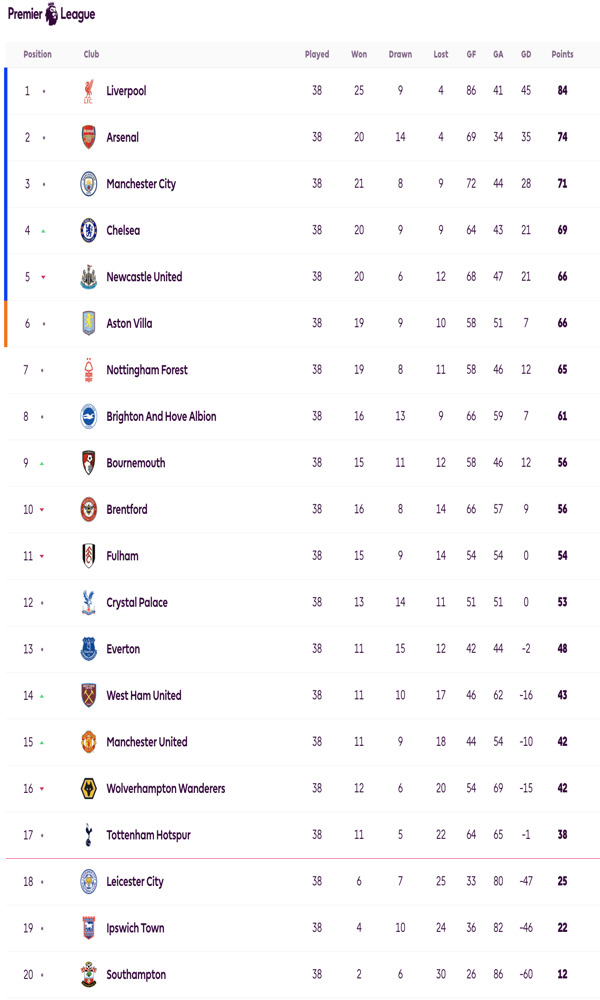

In [52]:
from PIL import Image
# 
Image.open("example_images/24-25-pl.png").resize((600, 1000)) # for checking the image

In [53]:
pl_messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "example_images/24-25-pl.png",
            },
            {"type": "text", "text": "OCR and return markdown"},
        ],
    }
]

pl_rl_output = inference(rl_model, messages, temperature=0.2)#, do_sample=False)

In [55]:
print(rl_output[0])

<think>
</think>

```markdown
| Position | Club | Played | Won | Drawn | Lost | GF | GA | GD | Points |
|----------|------|-------|-----|------|------|----|----|----|--------|
| 1        | Liverpool | 38 | 25 | 9 | 4 | 86 | 41 | 45 | 84 |
| 2        | Arsenal | 38 | 20 | 14 | 4 | 69 | 34 | 35 | 74 |
| 3        | Manchester City | 38 | 21 | 8 | 9 | 72 | 44 | 28 | 71 |
| 4        | Chelsea | 38 | 20 | 9 | 9 | 64 | 43 | 21 | 69 |
| 5        | Newcastle United | 38 | 20 | 6 | 12 | 68 | 47 | 21 | 66 |
| 6        | Aston Villa | 38 | 19 | 9 | 10 | 58 | 51 | 7 | 66 |
| 7        | Nottingham Forest | 38 | 19 | 8 | 11 | 58 | 46 | 12 | 65 |
| 8        | Brighton And Hove Albion | 38 | 16 | 13 | 9 | 66 | 59 | 7 | 61 |
| 9        | Bournemouth | 38 | 15 | 11 | 12 | 58 | 46 | 12 | 56 |
| 10       | Brentford | 38 | 16 | 8 | 14 | 66 | 57 | 9 | 56 |
| 11       | Fulham | 38 | 15 | 9 | 14 | 54 | 54 | 0 | 54 |
| 12       | Crystal Palace | 38 | 13 | 14 | 11 | 51 | 51 | 0 | 53 |
| 13       | Everton | 3

In [75]:
# handwritten 
menu_messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "example_images/menu.jpeg",
            },
            {"type": "text", "text": "OCR 图中文字"},
        ],
    }
]
print(menu_messages)
sft_output = inference(sft_model, messages, temperature=0.2)#, do_sample=False)

[{'role': 'user', 'content': [{'type': 'image', 'image': 'example_images/menu.jpeg'}, {'type': 'text', 'text': 'OCR 图中文字'}]}]


In [77]:
print(sft_output[0])

<think>
用户现在需要把菜单上的文字OCR出来，要逐行识别。首先看菜单的结构，分为Skewers + Sides、Curries、Sweet Roti、Salads、Wok、Desserts等部分。先从顶部开始：

Samsen - a Thai Street Food eatery
bringing bold flavours from Thailand to bowls in Hong Kong.

然后Skewers + Sides 小菜部分：
沙爹雞串燒
chargrilled chicken satay
cucumber relish and spicy peanut sauce
138.00
香辣虎蝦串燒
chargrilled coconut & chili prawn skewers
pickled ginger and lime
148.00
秘製和牛串燒
chargrilled Wagyu beef skewers (200gm)
spicy tomato and Thai herb relish
198.00
鮮製泰式飛餅（宜配咖哩）
fresh made Roti
crispy Thai pancake (perfect with our curry!)
58.00
炒泰國通菜
wok fried Thai watercress
chili, garlic and yellow beans
88.00
泰國絲苗白飯
Thai jasmine rice
30.00

Curries 咖哩部分：
泰北咖哩雞金麵
“Khao Soi” of curried chicken with fresh egg noodles
pickled mustard greens and herbs
158.00
泰北咖哩牛金麵
“Khao Soi” of curried beef with fresh egg noodles
pickled mustard greens and herbs
158.00
瑪莎曼咖哩和牛牛臉麵肉
“Massaman” curry of beef cheeks & potatoes
roasted onions and peanuts
258.00
特式姜黃咖哩虎蝦
spicy turmeric curry of tiger p